In [1]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt 
from sklearn.metrics import precision_recall_fscore_support
import Scripts.Data_Read_Prepare as Data_Prepare
import Scripts.Fake_News_Detection_SVM as SVM_classifier
import Scripts.Fake_News_Detection_PA as PA_classifier
import Scripts.Fake_News_Detection_XGBoost as XGBoost_classifier
import Scripts.Fake_News_Detection_LSTM as LSTM_classifier
import Scripts.Fake_News_Detection_BiLSTM as BiLSTM_classifier
import Scripts.Fake_News_Detection_Stacked_MLP as MLP_classifier

Loading data from datasets

In [2]:
data_train, data_valid, data_test = Data_Prepare.read_data()
data_train.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver


In [3]:
data_train = Data_Prepare.combine_classes(data_train)
data_valid = Data_Prepare.combine_classes(data_valid)
data_test = Data_Prepare.combine_classes(data_test)
data_train.head(3)

,label,sentence
0,0,abortion dwayne-bohac State representative Tex...
1,0,"energy,history,job-accomplishments scott-surov..."
2,1,foreign-policy barack-obama President Illinois...


Preproccesing

In [4]:
data_train, data_valid, data_test = Data_Prepare.do_preprocessing(data_train, data_valid, data_test,"no_stem")

data_preprocessing_without_stem done!


In [5]:
data_train['label'].value_counts(normalize='true')

0    0.644727
1    0.355273
Name: label, dtype: float64

In [6]:
# Combine the training and validation datasets for training
data_set_all = pd.concat([data_train, data_valid, data_test])
data_train_valid = pd.concat([data_train, data_valid])

X_train_valid = data_train_valid['sentence']
y_train_valid = data_train_valid['label']
X_test = data_test['sentence']
y_test = data_test['label']

In [7]:
#plot_data_length(data_set_all)

Vectorizing

In [8]:
X_train_valid_vectorized, X_test_vectorized,vocab_size, X_train_valid_sequences, X_test_sequences =Data_Prepare.tfidf_vectorizer(X_train_valid, X_test)

Vectorizing done!


SMOTE

In [12]:
X_train_valid_resampled, y_train_valid_resampled = Data_Prepare.oversampling_data(X_train_valid_vectorized,y_train_valid)
X_train_valid_resampled_sequences = Data_Prepare.pad_sequences(X_train_valid_resampled.toarray(),
                                                      maxlen=250, truncating='post', padding='post')

Before SMOTE: Counter({0: 7466, 1: 4058})
After SMOTE: Counter({1: 7466, 0: 7466})


## 1- SVM

In [13]:
svm_predictions, svm_train_valid_predictions =SVM_classifier.train_svm(X_train_valid_resampled, y_train_valid_resampled, X_test_vectorized)

Execution time of SVM: 159.74 seconds


In [14]:
svm_accuracy, svm_precision, svm_recall, svm_fscore = SVM_classifier.svm_metrics(svm_predictions, y_test)

SVM - accuracy: 0.6211523283346487
SVM - Precision: 0.4684317718940937
SVM - Recall: 0.512249443207127
SVM - F-score: 0.48936170212765956


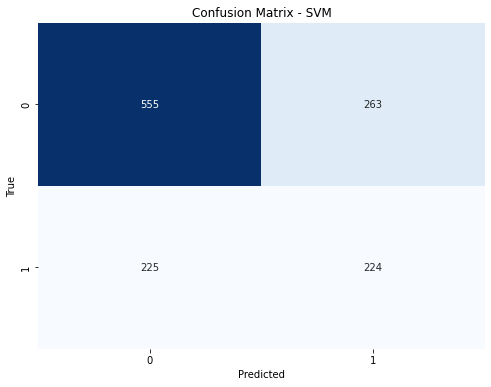

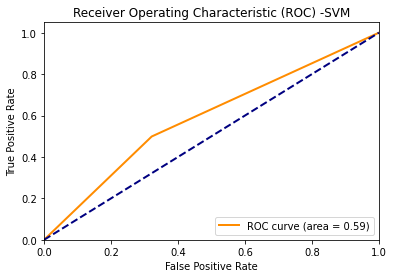

In [22]:
SVM_classifier.svm_confusion_matrix_plot(svm_predictions, y_test)
SVM_classifier.svm_roc_plot(svm_predictions, y_test)

## 2-Passive Aggressive

In [37]:
pa_predictions,pa_train_valid_predictions,pa_scores = PA_classifier.train_pa(X_train_valid_resampled, y_train_valid_resampled,X_test_vectorized)

Execution time of PA: 0.05 seconds


In [38]:
pa_accuracy, pa_precision, pa_recall, pa_fscore = PA_classifier.pa_metrics(pa_predictions, y_test)

PA - accuracy: 0.6148382004735596
PA - Precision: 0.46787479406919275
PA - Recall: 0.6325167037861915
PA - F-score: 0.5378787878787878


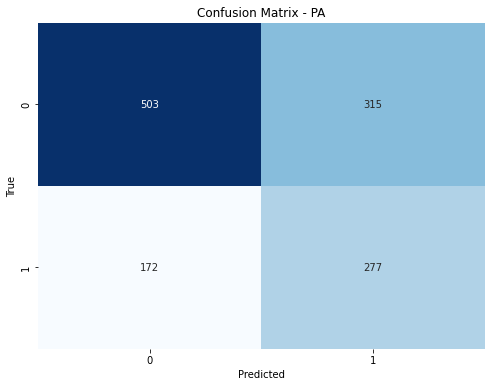

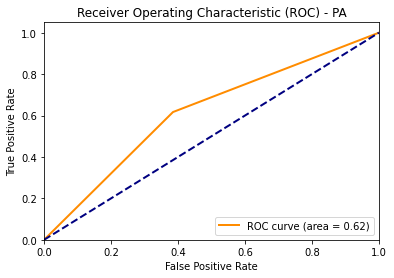

In [20]:
PA_classifier.pa_confusion_matrix_plot(pa_predictions, y_test)
PA_classifier.pa_roc_plot(pa_predictions, y_test)

## 3-XGBoost

In [39]:
xgb_predictions, xgb_train_valid_predictions, xgb_pred = XGBoost_classifier.train_xgboost(X_train_valid_resampled,y_train_valid_resampled, X_test_vectorized,y_test)

Execution time of PA: 86.32 seconds


XGBoost - accuracy: 0.611681136543015
XGBoost - Precision: 0.4601113172541744
XGBoost - Recall: 0.5523385300668151
XGBoost - F-score: 0.5020242914979758


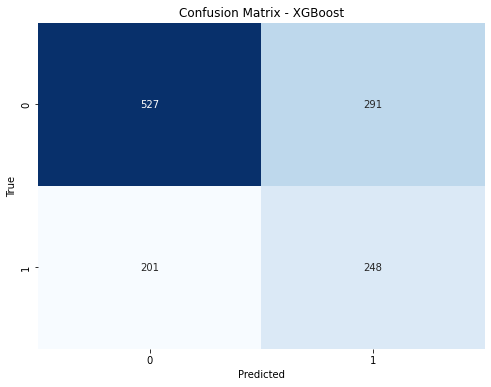

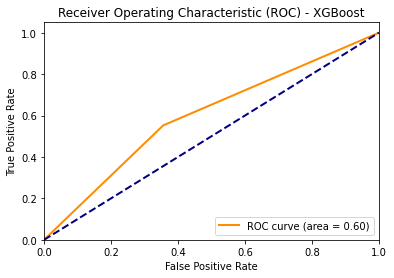

In [40]:
xgb_accuracy, xgb_precision, xgb_recall, xgb_fscore = XGBoost_classifier.xgb_metrics(xgb_predictions, y_test)
XGBoost_classifier.xgb_confusion_matrix_plot(xgb_predictions, y_test)
XGBoost_classifier.xgb_roc_plot(xgb_predictions, y_test)

Deep Learning Preproccess

In [10]:
X_train_tokenized,X_valid_tokenized,X_test_tokenized, vocab_size = Data_Prepare.data_tokenizer(data_train['sentence'],data_valid['sentence'],data_test['sentence'], data_set_all)

In [14]:
embedding_matrix,X_train_word2vec, X_valid_word2vec, X_test_word2vec = Data_Prepare.word2vec_embed(X_train_tokenized,X_valid_tokenized,X_test_tokenized)

Word2Vec embedding done!


In [23]:
X_train_sequences,X_valid_sequences,X_test_sequences=LSTM_classifier.pad_sequence_data(X_train_tokenized,X_valid_tokenized,X_test_tokenized)
y_train = data_train['label'].values
y_valid = data_valid['label'].values
y_test = data_test['label'].values

In [35]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train_sequences = pad_sequences(X_train_valid_resampled, maxlen=300)


## 4-LSTM

In [15]:
embedding_matrix,X_train_t_v, y_train_t_v, X_test_t_v, y_test_t_v, vocab_size = Data_Prepare.tokenize_vectorize(data_set_all, data_train_valid, data_test)

In [16]:
lstm_model, lstm_history = LSTM_classifier.train_lstm(vocab_size, embedding_matrix, X_train_t_v,
                                                      y_train_t_v,5,100)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embeddings (Embedding)      (None, 300, 150)          1828950   
                                                                 
 lstm_layer1 (LSTM)          (None, 300, 128)          142848    
                                                                 
 lstm_layer2 (LSTM)          (None, 300, 64)           49408     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 50)                3250      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                        

In [17]:
lstm_model.predict(X_test_t_v)

40/40 [==============================] - 5s 102ms/step


array([[0.32097724],
       [0.47948685],
       [0.2195961 ],
       ...,
       [0.39950123],
       [0.3860425 ],
       [0.36088827]], dtype=float32)

In [18]:
lstm_train_valid_predictions, lstm_predictions = LSTM_classifier.predict_lstm(lstm_model,X_train_t_v, X_test_t_v)

40/40 [==============================] - 5s 114ms/step


LSTM - Accuracy: 0.6511444356748224
LSTM - Precision: 0.5079726651480638
LSTM - Recall: 0.49665924276169265
LSTM - F-score: 0.5022522522522522


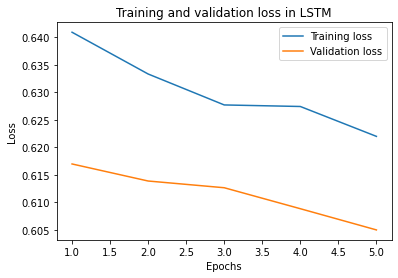

NameError: name 'confusion_matrix' is not defined

In [20]:
lstm_accuracy, lstm_precision, lstm_recall, lstm_fscore = LSTM_classifier.lstm_metrics(lstm_predictions, y_test_t_v)
LSTM_classifier.lstm_loss_plot(lstm_history)
LSTM_classifier.lstm_confusion_matrix_plot(lstm_predictions, y_test_t_v)

## 5-BiLSTM

In [8]:
embedding_matrix,X_train_t_v, y_train_t_v, X_test_t_v, y_test_t_v, vocab_size = Data_Prepare.tokenize_vectorize(data_set_all, data_train_valid, data_test)

In [ ]:
bilstm_model, bilstm_history = BiLSTM_classifier.train_bilstm(vocab_size,
                                                              X_train_t_v,
                                                              y_train_t_v, 5,68)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 150)          1828950   
                                                                 
 bidirectional (Bidirectiona  (None, 300, 256)         285696    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,283,159
Trainable params: 454,209
Non-tr

In [ ]:
bilstm_train_predictions, bilstm_predictions = BiLSTM_classifier.predict_bilstm(bilstm_model, X_test_sequences)
BiLSTM_classifier.bilstm_loss_plot(bilstm_history)
BiLSTM_classifier.bilstm_confusion_matrix_plot(bilstm_predictions, y_test)
bilstm_roc_plot(bilstm_predictions, y_test)

## Evaluate Ensemblely!

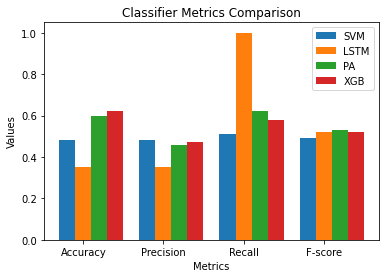

In [457]:
metrics = ['Accuracy','Precision','Recall','F-score'] 
svm = [svm_accuracy, svm_precision, svm_recall, svm_fscore] 
pa=[pa_accuracy, pa_precision, pa_recall, pa_fscore]
xgb=[xgb_accuracy, xgb_precision, xgb_recall, xgb_fscore]
lstm = [lstm_accuracy, lstm_precision, lstm_recall, lstm_fscore] 
bilstm = [bilstm_accuracy, bilstm_precision, bilstm_recall, bilstm_fscore] 

bar_width = 0.18 
index = np.arange(len(metrics))
plt.bar(index, svm, bar_width, label='SVM')
plt.bar(index + bar_width, pa, bar_width, label='PA')
plt.bar(index + 2*bar_width, xgb, bar_width, label='XGB')
plt.bar(index + 3*bar_width, lstm, bar_width, label='LSTM')
plt.bar(index + 4*bar_width, bilstm, bar_width, label='BiLSTM')

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Classifier Metrics Comparison')

plt.xticks(index + bar_width, metrics)
plt.legend()
plt.show()
        

In [459]:
import numpy as np
def ensemble_prediction():   
    votes = np.array([list(row) for row in zip(svm_predictions ,xgb_predictions, pa_predictions, lstm_predictions, bilstm_predictions)])
    column_sums = np.sum(votes, axis=1)
    averages_vote = []
    for column_sum in column_sums:
        average = column_sum / 5
        averages_vote.append(average.round())
    return averages_vote

In [460]:
y_pred_ensemble = ensemble_prediction()

accuracy = sum(y_pred_ensemble == y_test) / len(y_test)

precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred_ensemble, average='binary')
print("Model - accuracy:", accuracy)
print("Model - Precision:", precision)
print("Model - Recall:", recall)
print("Model - F-score:", fscore)

Model4 - accuracy: 0.6172059984214681
Model4 - Precision: 0.4673913043478261
Model4 - Recall: 0.5746102449888641
Model4 - F-score: 0.5154845154845155


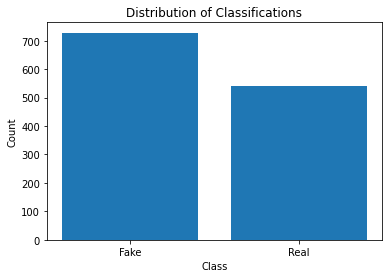

In [379]:
#Visualizing distribution of predeiction of ensemble clas
class_counts = np.bincount(y_pred_ensemble)
plt.bar(range(len(class_counts)), class_counts)
class_labels = ['Fake', 'Real']
plt.xticks(range(len(class_counts)), class_labels)
plt.title('Distribution of Classifications')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

## MLP Classifier

In [461]:
xgb_train_valid_predictions = np.array(xgb_train_valid_predictions)
xgb_predictions= np.array(xgb_predictions)

stacked_X_train = np.hstack((X_train_valid_resampled.toarray(), 
                             svm_train_valid_predictions.reshape((-1, 1)),
                             xgb_train_valid_predictions.reshape((-1, 1)),
                             lstm_train_valid_predictions.reshape((-1, 1)),
                             bilstm_train_valid_predictions.reshape((-1, 1)),
                             pa_train_valid_predictions.reshape((-1, 1))))
stacked_X_test = np.hstack((X_test_vectorized.toarray(), 
                            svm_predictions.reshape((-1, 1)),
                            xgb_predictions.reshape((-1, 1)),
                            lstm_predictions.reshape((-1, 1)),
                            bilstm_predictions.reshape((-1, 1)),
                            pa_predictions.reshape((-1, 1))))


In [463]:
mlp_predictions = build_mlp(stacked_X_train, y_train_valid_resampled,stacked_X_test)

Execution time of MLP: 142.97 seconds


In [ ]:
mlp_metrics(mlp_predictions, y_test)

In [462]:
# from sklearn.neural_network import MLPClassifier
# import time

# def build_mlp():
#     start_time = time.time()
    
#     mlp_classifier = MLPClassifier()
#     mlp_classifier.fit(stacked_X_train, y_train_valid_resampled)

#     mlp_predictions = mlp_classifier.predict(stacked_X_test)
    
#     end_time = time.time()
#     execution_time = end_time - start_time
#     print("Execution time of MLP: {:.2f} seconds".format(execution_time))
#     return mlp_predictions

In [464]:
# from sklearn.metrics import accuracy_score,f1_score, classification_report

# f_score = f1_score(y_test, mlp_predictions, average='micro')
# accuracy = accuracy_score(y_test, mlp_predictions)
# print(classification_report(y_test, mlp_predictions))
# print("Model4 - MLP F-score:", f_score)
# print("Model4 - MLP Accuracy:", accuracy)

              precision    recall  f1-score   support

           0       0.72      0.70      0.71       818
           1       0.48      0.51      0.50       449

    accuracy                           0.63      1267
   macro avg       0.60      0.60      0.60      1267
weighted avg       0.64      0.63      0.63      1267

Model4 - MLP F-score: 0.6314127861089187
Model4 - MLP Accuracy: 0.6314127861089187
